<a href="https://colab.research.google.com/github/z-tufekci/DeepLearning/blob/main/FinRL_MultiStock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INSTALL FinRL Pack and IMPORT libs

## Install Packages

In [ ]:
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

In [ ]:
!pip install git+https://github.com/AI4Finance-Foundation/FinRL-Meta.git

## Import FinRL libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.apps import config

from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent # Deep Reinforcement Learning Agent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

## Import Stock time series and Technical Indicators

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


DOW30 STOCKS BETWEEN 2000-2016 TRAINING / 2016-2020 TRADING

In [ ]:
#del df
filenames = ['AAPL','AXP','AMGN','BA','CAT','CSCO','CVX','DIS','GS','HD','HON','IBM','INTC','JNC','JPM', 'KO', 'MCD','MMM','MRK','MSFT','NKE','PG','TRV','UNH','VZ','WBA','WMT'] 
df_temps = []
for fn in filenames :
    df_temp = pd.read_csv('gdrive/My Drive/DeepLearning/'+fn+'.csv', sep=';')
    df_temp = df_temp.iloc[33:, 0:9]
    df_temp['tic'] = fn
    df_temps.append(df_temp)
df = pd.concat(df_temps, ignore_index=True)


In [ ]:
df_baseline = get_baseline(ticker='^DJI', start='2016-09-15', end='2020-09-04')
stats = backtest_stats(df_baseline, value_col_name = 'close')

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1000, 8)
Annual return          0.117401
Cumulative returns     0.553480
Annual volatility      0.212828
Sharpe ratio           0.629390
Calmar ratio           0.316563
Stability              0.638812
Max drawdown          -0.370862
Omega ratio            1.154682
Sortino ratio          0.862698
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.864553
Daily value at risk   -0.026282
dtype: float64


## PROCESS DATA

In [ ]:
print(df.head())
print(df.shape)

         Date     Close          RSI  TNRSI  ...      SO      CCI     PPO   tic
0  20.10.2000  0,348214  32,56857732  90,52  ...   10,59   -53,88  -33,36  AAPL
1  23.10.2000  0,363839  42,28833544   88,3  ...   30,67   -46,95  -32,46  AAPL
2  24.10.2000  0,337054  31,37251457  75,88  ...   -1,33   -63,41  -31,95  AAPL
3  25.10.2000  0,330357  34,59452129  67,97  ...  -11,32   -77,68  -31,44  AAPL
4  26.10.2000  0,330357  33,87974931  55,76  ...       0  -108,46  -30,79  AAPL

[5 rows x 10 columns]
(134973, 10)


CHANGE TO DATETIME OBJECT

In [ ]:
from datetime import datetime
df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x, "%d.%m.%Y") )
df.head()

,Date,Close,RSI,TNRSI,BB PERCENT,ROC-14,SO,CCI,PPO,tic
0,2000-10-20,"0,348214","32,56857732","90,52","34,32520531","-19,5877479","10,59","-53,88","-33,36",AAPL
1,2000-10-23,"0,363839","42,28833544","88,3","37,90456608","-8,683659691","30,67","-46,95","-32,46",AAPL
2,2000-10-24,"0,337054","31,37251457","75,88","35,97616928","-20,10571852","-1,33","-63,41","-31,95",AAPL
3,2000-10-25,"0,330357","34,59452129","67,97","36,07471499","-16,14729943","-11,32","-77,68","-31,44",AAPL
4,2000-10-26,"0,330357","33,87974931","55,76","18,07877184","-16,61967921",0,"-108,46","-30,79",AAPL


SORT BY DATE

In [ ]:
df = df.sort_values(by=['Date','tic'], ignore_index=True)
df.head()

,Date,Close,RSI,TNRSI,BB PERCENT,ROC-14,SO,CCI,PPO,tic
0,2000-10-20,"0,348214","32,56857732","90,52","34,32520531","-19,5877479","10,59","-53,88","-33,36",AAPL
1,2000-10-20,"68,75","55,08474576","64,67","69,54987942","4,562737643","113,16","59,69","-1,83",AMGN
2,2000-10-20,"49,071507","32,26836566","48,36","38,2883197","-11,01190663","37,64","-36,33","-2,56",AXP
3,2000-10-20,60,"54,41696113","69,08","41,15684783","2,673796791","77,5","-32,0451749","0,09",BA
4,2000-10-20,"15,34375","25,64102564","41,16","18,88486644","-10,40145985","16,47","-99,14","-5,21",CAT


In [ ]:
df.rename(columns={'Close': 'close'}, inplace=True)
df.rename(columns={'Date': 'date'}, inplace=True)
df['close'] = df['close'].apply(lambda x: float(x.replace(",", ".")))
df['RSI'] = df['RSI'].apply(lambda x: float(x.replace(",", ".")))
df['TNRSI'] = df['TNRSI'].apply(lambda x: float(x.replace(",", ".")))
df['BB PERCENT'] = df['BB PERCENT'].apply(lambda x: float(x.replace(",", ".")))
df['ROC-14'] = df['ROC-14'].apply(lambda x: float(x.replace(",", ".")))
df['SO'] = df['SO'].apply(lambda x: float(x.replace(",", ".")))
df['PPO'] = df['PPO'].apply(lambda x: float(x.replace(",", ".")))
df['CCI'] = df['CCI'].apply(lambda x: float(x.replace(",", ".")))
df.head()

,date,close,RSI,TNRSI,BB PERCENT,ROC-14,SO,CCI,PPO,tic
0,2000-10-20,0.348214,32.568577,90.52,34.325205,-19.587748,10.59,-53.880000,-33.36,AAPL
1,2000-10-20,68.750000,55.084746,64.67,69.549879,4.562738,113.16,59.690000,-1.83,AMGN
2,2000-10-20,49.071507,32.268366,48.36,38.288320,-11.011907,37.64,-36.330000,-2.56,AXP
3,2000-10-20,60.000000,54.416961,69.08,41.156848,2.673797,77.50,-32.045175,0.09,BA
4,2000-10-20,15.343750,25.641026,41.16,18.884866,-10.401460,16.47,-99.140000,-5.21,CAT


SPLIT DATA AS TRAIN AND TEST

In [ ]:
#TRAIN
training = data_split(df, '2000-10-20','2016-09-15')
print(training.shape)
#TEST
trading = data_split(df, '2016-09-15','2020-09-04')
print(trading.shape)

(107973, 10)
(27000, 10)


## Action Space and State Space
Normally, Three are 3 actions: {-1, 0, 1}, where 
*   Selling one share = -1
*   Holding one share = 0
*   Buying one share = 1

Also, It can be represented for multiple shares. 
An action space: {-k,…,-1, 0, 1, …, k}
*   the number of shares to buy = k
*   the number of shares to sell= -k 

For example, 
* Buy 10 shares of AAPL = 10
* Sell 10 shares of AAPL = -10 

In [ ]:
ratio_list = ['RSI','TNRSI','BB PERCENT','ROC-14','SO','CCI','PPO'] # Technical Indicator List
stock_dimension = len(training.tic.unique()) # IT CAN BE ONE STOCK OR MULTIPLE STOCKS
state_space = 1 + 2*stock_dimension + len(ratio_list)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

# Parameters for the environment
env_kwargs = {
    "hmax": 100, # -100<=K<=100 IT MEANS 100*2+1=201 ACTION SPACE  [1 0 -1]= 3 Act space
    "initial_amount": 100000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": ratio_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
   
}
#Establish the training environment using StockTradingEnv() class
e_train_gym = StockTradingEnv(df = training, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()


Stock Dimension: 27, State Space: 244


# MODEL1: ⚽ Advantage Actor Critic (A2C) 


In [ ]:
agent = DRLAgent(env = env_train)

In [ ]:
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device


In [ ]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

## TEST Advantage Actor Critic (A2C)

In [ ]:
e_trade_gym = StockTradingEnv(df = trading, **env_kwargs)
df_account_value_a2c, df_actions = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym)

hit end!


In [ ]:
print(df_account_value_a2c.shape)
df_account_value_a2c.tail()

(1000, 2)


,date,account_value
995,2020-08-28,108956.814870
996,2020-08-31,109157.879767
997,2020-09-01,110467.718444
998,2020-09-02,112616.101999
999,2020-09-03,110036.945487


In [ ]:
df_actions

,AAPL,AMGN,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,HON,IBM,INTC,JNC,JPM,KO,MCD,MMM,MRK,MSFT,NKE,PG,TRV,UNH,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-15,100,0,100,0,0,0,100,100,100,0,100,0,0,0,1,0,0,100,0,0,100,0,100,0,100,45,0
2016-09-16,-100,100,100,0,100,55,0,0,0,0,-100,0,0,0,-1,0,0,-100,0,0,100,100,-100,0,-100,0,0
2016-09-19,0,0,0,43,-100,100,-100,0,-100,0,0,100,0,0,100,0,0,0,1,100,-100,0,0,0,0,-45,100
2016-09-20,0,-40,0,0,0,-100,0,63,100,100,0,-100,0,100,0,0,0,0,-1,0,-100,-100,0,0,0,0,-100
2016-09-21,0,-60,-100,100,0,87,0,100,0,-100,0,0,0,-100,100,100,0,0,0,0,100,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-27,0,0,0,0,0,0,-37,0,0,-20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,65
2020-08-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-08-31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# MODEL 2: ⛽ Deep Deterministic Policy Gradient (DDPG)

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

## TEST Deep Deterministic Policy Gradient (DDPG)

In [ ]:
e_trade_gym = StockTradingEnv(df = trading, **env_kwargs)
df_account_value_ddpg, df_actions = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym)

hit end!


In [ ]:
print(df_account_value_ddpg.shape)
df_account_value_ddpg.tail()

(1000, 2)


,date,account_value
995,2020-08-28,150598.654184
996,2020-08-31,149600.173643
997,2020-09-01,150222.644783
998,2020-09-02,152012.974203
999,2020-09-03,146876.233632


In [ ]:
df_actions

,AAPL,AMGN,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,HON,IBM,INTC,JNC,JPM,KO,MCD,MMM,MRK,MSFT,NKE,PG,TRV,UNH,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-15,100,0,0,100,100,0,100,100,0,100,0,0,100,100,0,0,0,0,100,48,0,0,100,0,-1,100,0
2016-09-16,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-09-19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-09-20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-09-21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-08-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-08-31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# MODEL3: ❎ Proximal Policy Optimization (PPO) 

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device


In [ ]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000)

## TEST Proximal Policy Optimization (PPO)

In [ ]:
e_trade_gym = StockTradingEnv(df = trading, **env_kwargs)
df_account_value_ppo, df_actions = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym)

hit end!


In [ ]:
print(df_account_value_ppo.shape)
df_account_value_ppo.tail()

(1000, 2)


,date,account_value
995,2020-08-28,100647.555800
996,2020-08-31,99388.744285
997,2020-09-01,100737.000740
998,2020-09-02,101822.297280
999,2020-09-03,99755.422846


In [ ]:
df_actions

,AAPL,AMGN,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,HON,IBM,INTC,JNC,JPM,KO,MCD,MMM,MRK,MSFT,NKE,PG,TRV,UNH,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-15,0,0,17,0,87,54,0,0,0,6,51,0,0,85,0,100,0,78,56,0,100,0,51,100,0,0,58
2016-09-16,0,0,-17,100,-26,0,0,0,100,-1,0,0,100,-85,0,-12,0,62,100,0,2,0,-51,-93,100,0,0
2016-09-19,0,0,0,-18,-1,0,0,0,-28,0,-51,0,-23,0,0,0,100,-100,0,0,1,0,100,-7,100,99,-58
2016-09-20,1,0,100,-82,24,-30,0,0,-33,-5,100,0,40,-1,100,57,-100,-40,1,0,100,0,100,0,-51,-99,0
2016-09-21,-1,0,-100,0,0,98,0,0,-39,0,57,0,-19,0,-100,-100,0,100,0,1,-40,0,36,0,-92,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-27,0,83,0,0,0,-18,0,0,-22,0,0,0,0,0,0,2,0,-4,-33,0,0,-6,-73,0,0,1,-21
2020-08-28,0,-83,100,0,0,0,100,0,0,0,-13,0,0,0,0,-2,0,0,0,0,0,0,-29,0,100,48,0
2020-08-31,0,0,0,0,0,0,-100,0,-18,0,-13,0,0,100,100,0,0,0,0,0,0,-46,32,0,-25,0,-51


# MODEL4: ⛄ Twin-Delayed Deep Deterministic Policy Gradient Agents (TD3)

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device


In [ ]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=50000)

## TEST Twin-Delayed Deep Deterministic Policy Gradient Agents (TD3)

In [ ]:
e_trade_gym = StockTradingEnv(df = trading, **env_kwargs)
df_account_value_td3, df_actions = DRLAgent.DRL_prediction(
    model=trained_td3, 
    environment = e_trade_gym)

In [ ]:
print(df_account_value_td3.shape)
df_account_value_td3.tail()

# MODEL 5: ⏲ Soft Actor-Critic (SAC)

In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

In [ ]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=50000)

## TEST Soft Actor-Critic (SAC)

In [ ]:
e_trade_gym = StockTradingEnv(df = trading, **env_kwargs)
df_account_value_sac, df_actions = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym)

In [ ]:
print(df_account_value_sac.shape)
df_account_value_sac.tail()

# Back Test Plot

In [ ]:
print("==============Get Backtest Results===========")
perf_stats_all = backtest_stats(account_value=df_account_value_ddpg)
perf_stats_all = pd.DataFrame(perf_stats_all)
print("==============Get Baseline Results===========")
df_baseline = get_baseline(ticker='^DJI', start='2016-09-15', end='2020-09-04')
stats = backtest_stats(df_baseline, value_col_name = 'close')
stats = pd.DataFrame(stats)

==============Get Backtest Results===========
Annual return          0.101721
Cumulative returns     0.468762
Annual volatility      0.229051
Sharpe ratio           0.539342
Calmar ratio           0.251743
Stability              0.476329
Max drawdown          -0.404069
Omega ratio            1.128498
Sortino ratio          0.729744
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.912691
Daily value at risk   -0.028368
dtype: float64
==============Get Baseline Results===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1000, 8)
Annual return          0.117401
Cumulative returns     0.553480
Annual volatility      0.212828
Sharpe ratio           0.629390
Calmar ratio           0.316563
Stability              0.638812
Max drawdown          -0.370862
Omega ratio            1.154682
Sortino ratio          0.862698
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.

In [ ]:
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

In [ ]:
backtest_plot(df_account_value_ddpg, 
             baseline_ticker = '^DJI', 
             baseline_start = '2016-09-15',
             baseline_end = '2020-09-04')

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1000, 8)


Start date,2016-09-15
End date,2020-09-03
Total months,47
,Backtest
Annual return,10.172%
Cumulative returns,46.876%
Annual volatility,22.905%
Sharpe ratio,0.54
Calmar ratio,0.25
Stability,0.48
Max drawdown,-40.407%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,40.41,2020-02-12,2020-03-23,NaT,NaN
1,19.36,2018-10-03,2018-12-24,2019-06-20,187
2,11.46,2018-01-26,2018-04-02,2018-09-20,170
3,8.14,2019-07-15,2019-08-14,2019-09-11,43
4,4.20,2019-11-15,2020-01-31,2020-02-06,60


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


==============Compare to baseline buy-and-hold===========


Start date,2016-09-15
End date,2020-09-03
Total months,47
,Backtest
Annual return,10.172%
Cumulative returns,46.876%
Annual volatility,22.905%
Sharpe ratio,0.54
Calmar ratio,0.25
Stability,0.48
Max drawdown,-40.407%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,40.41,2020-02-12,2020-03-23,NaT,NaN
1,19.36,2018-10-03,2018-12-24,2019-06-20,187
2,11.46,2018-01-26,2018-04-02,2018-09-20,170
3,8.14,2019-07-15,2019-08-14,2019-09-11,43
4,4.20,2019-11-15,2020-01-31,2020-02-06,60


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


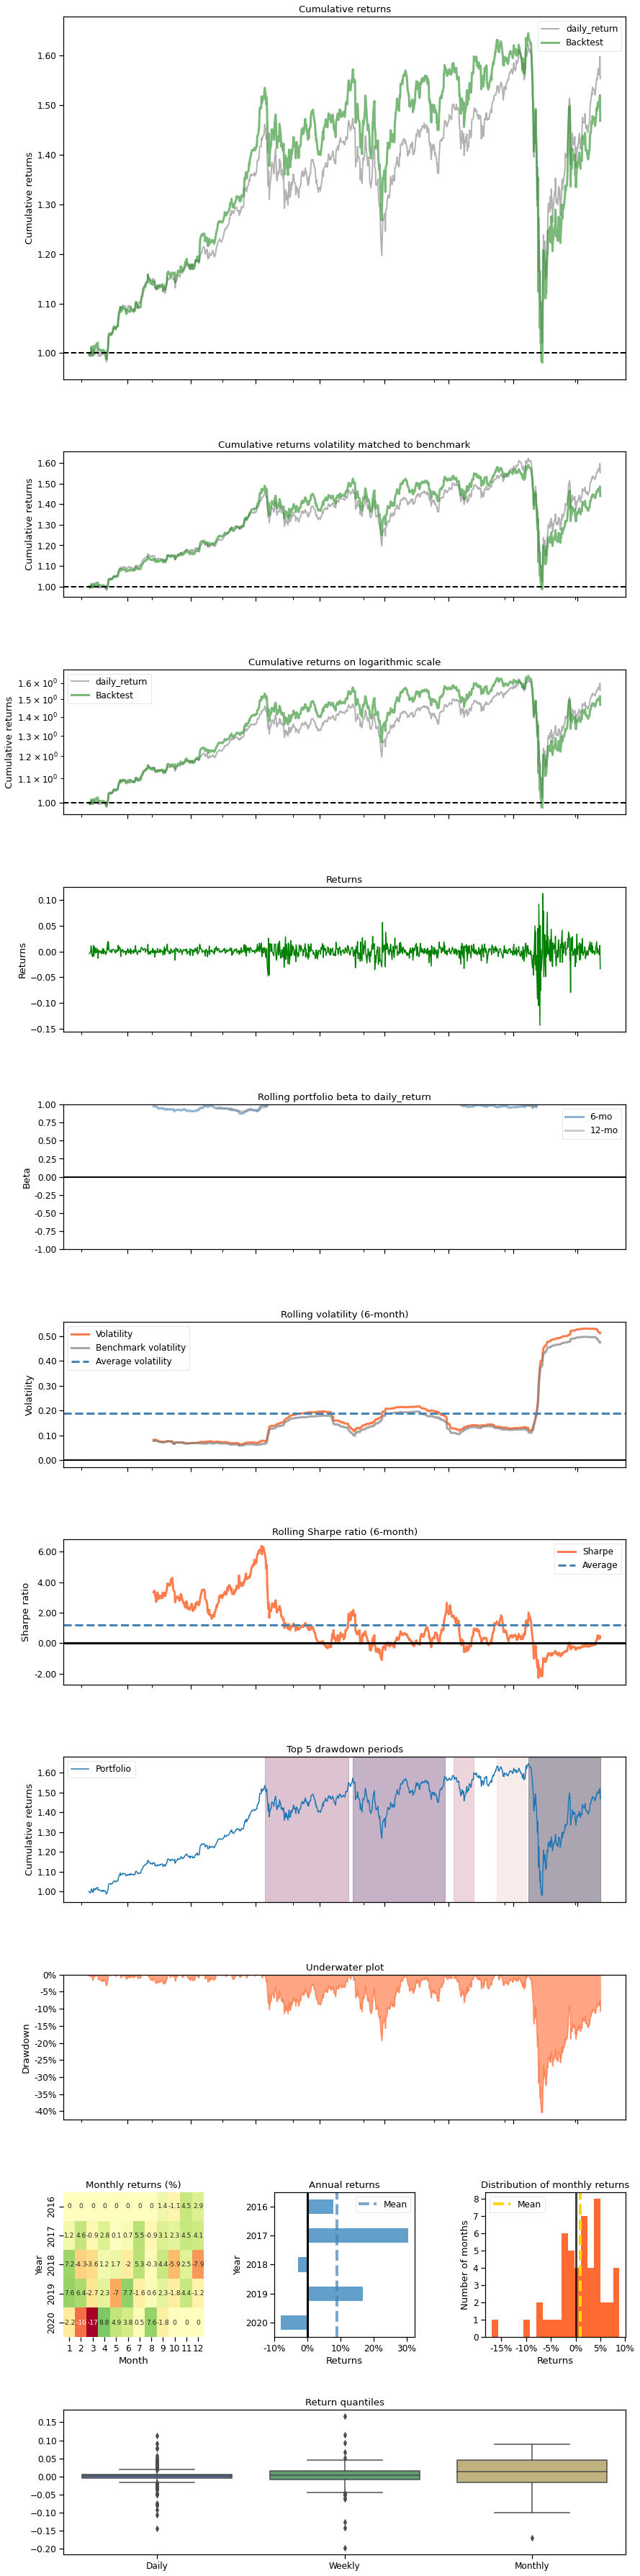

In [ ]:
import pyfolio
def backtest_plot():
    baseline_returns = get_daily_return(df_baseline, value_col_name="close") # This is current daily return 
    test_returns = get_daily_return(df_account_value_ddpg) # This is our offering strategy
    with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(
            returns=test_returns, benchmark_rets=baseline_returns, set_context=False
        )
print("==============Compare to baseline buy-and-hold===========")
%matplotlib inline
backtest_plot()